In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
# from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
# from torch.utils.data import Dataset, DataLoader
# from transformers import AdamW
# from transformers import get_linear_schedule_with_warmup
# from transformers import DataCollatorWithPadding

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Load and concatenate datasets
dataset_paths = ['/content/gdrive/MyDrive/Intro to Deep Learning - CSCI 4341/Final Project/data/dataset.csv', '/content/gdrive/MyDrive/Intro to Deep Learning - CSCI 4341/Final Project/data/Language Detection.csv']
dataframes = [pd.read_csv(path) for path in dataset_paths]
df = pd.concat(dataframes)


In [ ]:
# Convert language labels to integers
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Language'])

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Intro to Deep Learning - CSCI 4341/Final Project/Docs/Conversation.csv')

In [ ]:
df

,Unnamed: 0,question,answer
0,0,"hi, how are you doing?",i'm fine. how about yourself?
1,1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,3,no problem. so how have you been?,i've been great. what about you?
4,4,i've been great. what about you?,i've been good. i'm in school right now.
...,...,...,...
3720,3720,that's a good question. maybe it's not old age.,are you right-handed?
3721,3721,are you right-handed?,yes. all my life.
3722,3722,yes. all my life.,you're wearing out your right hand. stop using...
3723,3723,you're wearing out your right hand. stop using...,but i do all my writing with my right hand.


In [ ]:
df.shape

(32337, 3)

In [ ]:
# Convert language labels to integers
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Language'])

# Split the dataset into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Text'].to_numpy(),
    df['label'].to_numpy(),
    test_size=0.2,
    random_state=42)

In [ ]:
# Load the DistilBert tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

# Tokenize the texts
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True)

In [ ]:
# Define the TextDataset class
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
# Create the DataLoader for the training set
train_dataset = TextDataset(train_encodings, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=DataCollatorWithPadding(tokenizer))d

# Create the DataLoader for the validation set
val_dataset = TextDataset(val_encodings, val_labels)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=DataCollatorWithPadding(tokenizer))

In [ ]:
# Load the DistilBertForSequenceClassification model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased', num_labels=len(label_encoder.classes_))

# Define the optimizer and the learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_loader) * 3
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Train the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'pre_classifie

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(50):
    model.train()
    train_loss = 0
    total_correct = 0
    total_count = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        train_loss += loss.item() * batch['input_ids'].shape[0]
        loss.backward()
        optimizer.step()
        scheduler.step()
        _, predicted = torch.max(outputs.logits, 1)
        total_correct += (predicted == batch['labels']).sum().item()
        total_count += len(batch['labels'])

    train_accuracy = total_correct / total_count
    train_loss /= len(train_dataset)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_accuracy)
    print(f"Epoch {epoch} - Train loss: {train_loss:.3f}, Train accuracy: {train_accuracy:.3f}")

    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_count = 0
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            val_loss += loss.item() * batch['input_ids'].shape[0]
            _, predicted = torch.max(outputs.logits, 1)
            total_correct += (predicted == batch['labels']).sum().item()
            total_count += len(batch['labels'])

        val_loss /= len(val_dataset)
        val_accuracy = total_correct / total_count
        val_loss_history.append(val_loss)
        val_acc_history.append(val_accuracy)
        print(f"Epoch {epoch} - Validation accuracy: {val_accuracy:.3f}")

Epoch 0 - Train loss: 0.009, Train accuracy: 0.999
Epoch 0 - Validation accuracy: 0.991
Epoch 1 - Train loss: 0.009, Train accuracy: 0.999
Epoch 1 - Validation accuracy: 0.991
Epoch 2 - Train loss: 0.009, Train accuracy: 0.998
Epoch 2 - Validation accuracy: 0.991
Epoch 3 - Train loss: 0.009, Train accuracy: 0.999
Epoch 3 - Validation accuracy: 0.991
Epoch 4 - Train loss: 0.009, Train accuracy: 0.999
Epoch 4 - Validation accuracy: 0.991
Epoch 5 - Train loss: 0.009, Train accuracy: 0.999
Epoch 5 - Validation accuracy: 0.991
Epoch 6 - Train loss: 0.009, Train accuracy: 0.999
Epoch 6 - Validation accuracy: 0.991
Epoch 7 - Train loss: 0.009, Train accuracy: 0.999
Epoch 7 - Validation accuracy: 0.991
Epoch 8 - Train loss: 0.009, Train accuracy: 0.998
Epoch 8 - Validation accuracy: 0.991
Epoch 9 - Train loss: 0.009, Train accuracy: 0.998
Epoch 9 - Validation accuracy: 0.991
Epoch 10 - Train loss: 0.009, Train accuracy: 0.998
Epoch 10 - Validation accuracy: 0.991
Epoch 11 - Train loss: 0.009, 

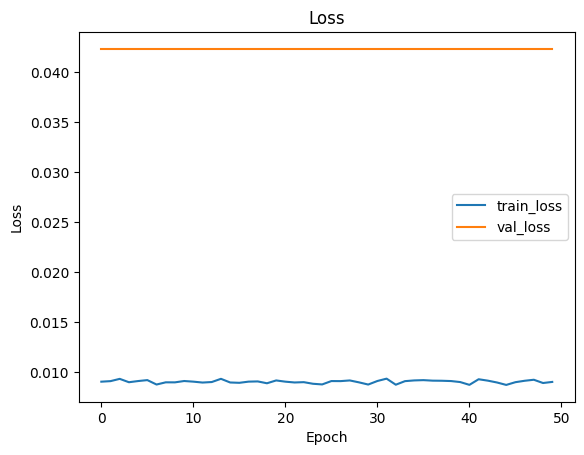

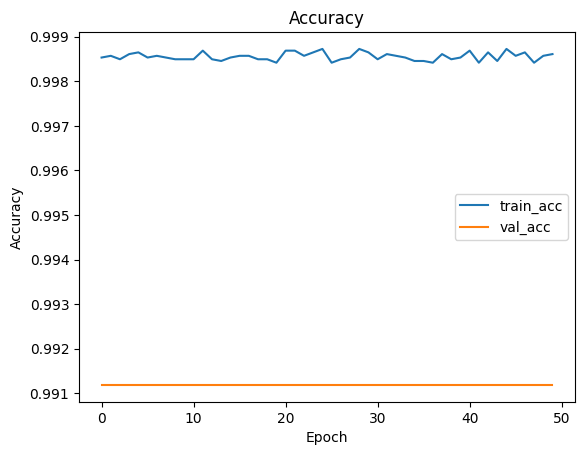

In [ ]:
import matplotlib.pyplot as plt

# Plot loss curves
plt.plot(train_loss_history, label='train_loss')
plt.plot(val_loss_history, label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy curves
plt.plot(train_acc_history, label='train_acc')
plt.plot(val_acc_history, label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Define the path to save your model
path = "/content/gdrive/MyDrive/Intro to Deep Learning - CSCI 4341/Final Project/model_best50.pt"
# Save the model
torch.save(model.state_dict(), path)
